# Оптический поток, трекинг
# Курс "Компьютерное зрение"

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

## 1. Оценка оптического потока
Оптический поток - это картина видимого движения объектов изображения между двумя последовательными кадрами, вызванного движением объекта или камеры. Это двумерное векторное поле, где каждый вектор представляет собой вектор смещения, показывающий перемещение точек от первого кадра ко второму.

<img src="https://docs.opencv.org/master/optical_flow_basic1.jpg" width="400" height="400">

Рисунок показывает движение мяча в 5 последовательных кадрах. Стрелка показывает его вектор смещения.  
Оптический поток основан на нескольких предположениях:
- Интенсивность пикселей объекта не меняется между последовательными кадрами.
- Соседние пиксели имеют аналогичное движение.

  
Допустим, у нас есть изображение в оттенках серого - матрица с яркостью пикселей. Определяем функцию $I (x, y, t)$, где $x$, $y$ - координаты пикселя, а $t$ - номер кадра. Функция $I (x, y, t)$ определяет точную интенсивность пикселей в кадре $t$.
Для начала предположим, что смещение объекта не меняет яркость пикселей, принадлежащих конкретному объекту, это означает, что $I (x, y, t) = I (x + \Delta x, y + \Delta y, t + \Delta t)$. В нашем случае $\Delta t = 1$. Основная задача - найти вектор движения $(\Delta x, \Delta y)$. 

<img src="https://learnopencv.com/wp-content/uploads/2020/08/object-displacement.png" width="600" height="400">

Используя разложение в ряд Тейлора, мы можем переписать $I (x, y, t) - I (x + \Delta x, y + \Delta y, t + \Delta t) = 0$ как $I'_x u + I'_y v = - I ' _t$, где $u = \frac {dx} {dt}$, $v = \frac {dy} {dt}$, и $I'_x, I'_y$ - градиенты изображения. Важно, что здесь мы предполагаем, что части ряда Тейлора более высокого порядка пренебрежимо малы, поэтому это приближение функции с использованием только разложения Тейлора первого порядка.  Теперь у нас есть две переменные $u$, $v$ и только одно уравнение, поэтому мы не можем решить уравнение прямо сейчас, но мы можем использовать некоторые приемы, которые будут раскрыты в следующих алгоритмах.
  
Существует два типа оптического потока, первый из которых называется разреженным оптическим потоком. Он вычисляет вектор движения для определенного набора объектов (например, обнаруженных углов на изображении). Следовательно, требуется некоторая предварительная обработка для извлечения признаков из изображения, которое будет основой для расчета оптического потока:
- Pyramid Lucas-Kanade
- Sparse RLOF  
  
Использование только разреженного набора признаков означает, что у нас не будет информации о движении пикселей, которые в нем не содержатся. Это ограничение можно снять с помощью алгоритмов плотного оптического потока, которые должны вычислять вектор движения для каждого пикселя изображения:
- Dense Pyramid Lucas-Kanade
- Farneback
- PCAFlow
- SimpleFlow
- RLOF
- DeepFlow
- DualTVL1

## 1.1. Считаем видео

In [2]:
def show_video(path):
    cap = cv2.VideoCapture(path)

    while(cap.isOpened()):
        ret, frame = cap.read()

        if ret == True:
            
            # Display the resulting frame
            cv2.imshow('Frame',frame)
            
            # Press Q on keyboard to  exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
                
        # Break the loop
        else: 
            break
    cap.release()
    cv2.destroyAllWindows()

In [3]:
path_1 = "Video/cars.mp4"
show_video(path_1)

In [4]:
path_2 = "Video/people.mp4"
show_video(path_2)

## 1.2. Lucas-Kanade algorithm (Sparse Optical Flow)
Метод Лукаса-Канаде обычно используется для расчета оптического потока для разреженного набора признаков. Основная идея этого метода основана на предположении о постоянстве локального движения, когда соседние пиксели имеют одинаковое направление смещения. Это предположение помогает получить приближенное решение уравнения с двумя переменными.

OpenCV имеет реализацию Pyramid Lucas & Kanade с улучшением алгоритма Ши-Томази для расчета оптического потока. 

Сначала нам нужно прочитать наше видео и получить признаки алгоритма Ши-Томази с первого кадра. Также здесь требуются некоторые вещи предварительной обработки для алгоритмов и визуализации.  
  
После этого мы можем начать нашу демонстрацию. Это циклический процесс, в котором мы считываем новый видеокадр и вычисляем признаки Ши-Томаси и оптический поток в цикле. Расчитанный оптический поток показан в виде цветных кривых.

In [5]:
def lucas_kanade_method(video_path):
    cap = cv2.VideoCapture(video_path)
    
    # params for ShiTomasi corner detection
    feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
    
    # Parameters for lucas kanade optical flow
    lk_params = dict(
        winSize=(15, 15),
        maxLevel=2,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
    )
    
    # Create some random colors
    color = np.random.randint(0, 255, (100, 3))
    
    # Take first frame and find corners in it
    ret, old_frame = cap.read()
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
    
    # Create a mask image for drawing purposes
    mask = np.zeros_like(old_frame)

    
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        try:
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            # calculate optical flow
            p1, st, err = cv2.calcOpticalFlowPyrLK(
                old_gray, frame_gray, p0, None, **lk_params
            )
            # Select good points
            good_new = p1[st == 1]
            good_old = p0[st == 1]
    
            # draw the tracks
            for i, (new, old) in enumerate(zip(good_new, good_old)):
                a, b = new.ravel()
                c, d = old.ravel()
                
                mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
                frame = cv2.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)
    
    
            img = cv2.add(frame, mask)
            cv2.imshow("frame", img)
        except:
            pass
        

        k = cv2.waitKey(25) & 0xFF
        if k == ord("q"):
            break
        if k == ord("c"):
            mask = np.zeros_like(old_frame)
              
        # Now update the previous frame and previous points
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1, 1, 2)
    cap.release()
    cv2.destroyAllWindows()

In [6]:
lucas_kanade_method(path_1)

In [7]:
lucas_kanade_method(path_2)

## 1.3. Farneback algorithm (Dense optical flow)
Выходные данные алгоритма плотного оптического потока могут быть закодированы как цветовая схема HSV. Используя функцию cv2.cartToPolar, мы можем преобразовать координаты смещения (dx, dy) в полярные координаты как длину радиус-вектора и угол для каждого пикселя. Здесь мы можем кодировать угол и длину радиус-вектора как оттенок и значение соответственно, в то время как насыщенность остается постоянной. Чтобы правильно показать оптический поток, нам нужно преобразовать HSV в формат BGR.  
  
Алгоритм Farneback был представлен в 2003 году и используется для расчета оптического потока для каждого пикселя изображения. Основная идея этого метода - аппроксимировать соседей каждого пикселя полиномом. Вообще говоря, в методе Лукаса-Канаде мы использовали линейное приближение, поскольку у нас было только разложение Тейлора первого порядка. Теперь мы увеличиваем точность приближения со значениями второго порядка. 

In [8]:
def Farneback(path):
    # Get a VideoCapture object from video and store it in vs
    vc = cv2.VideoCapture(path)
    # Read first frame
    ret, first_frame = vc.read()
    # Scale and resize image
    resize_dim = 600
    max_dim = max(first_frame.shape)
    scale = resize_dim/max_dim
    first_frame = cv2.resize(first_frame, None, fx=scale, fy=scale)
    # Convert to gray scale 
    prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)


    # Create mask
    mask = np.zeros_like(first_frame)
    # Sets image saturation to maximum
    mask[..., 1] = 255


    out = cv2.VideoWriter('video.mp4',-1,1,(600, 600))

    while(vc.isOpened()):
        # Read a frame from video
        ret, frame = vc.read()
        
        # Convert new frame format`s to gray scale and resize gray frame obtained
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, None, fx=scale, fy=scale)
    
        # Calculate dense optical flow by Farneback method
        # https://docs.opencv.org/3.0-beta/modules/video/doc/motion_analysis_and_object_tracking.html#calcopticalflowfarneback
        flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, pyr_scale = 0.5, levels = 5, winsize = 11, iterations = 5, poly_n = 5, poly_sigma = 1.1, flags = 0)
        # Compute the magnitude and angle of the 2D vectors
        magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        # Set image hue according to the optical flow direction
        mask[..., 0] = angle * 180 / np.pi / 2
        # Set image value according to the optical flow magnitude (normalized)
        mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
        # Convert HSV to RGB (BGR) color representation
        rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
        
        # Resize frame size to match dimensions
        frame = cv2.resize(frame, None, fx=scale, fy=scale)
        
        # Open a new window and displays the output frame
        dense_flow = cv2.addWeighted(frame, 1,rgb, 2, 0)
        cv2.imshow("Dense optical flow", dense_flow)
        out.write(dense_flow)
        # Update previous frame
        prev_gray = gray
        # Frame are read by intervals of 1 millisecond. The programs breaks out of the while loop when the user presses the 'q' key
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    # The following frees up resources and closes all windows
    vc.release()
    
    cv2.destroyAllWindows()


In [9]:
Farneback(path_1)

In [10]:
Farneback(path_2)

## 2. Particle Image Velocimetry
Велосиметрия по изображению частиц (PIV) - это оптический метод визуализации потока, используемый в исследованиях. Он используется для получения мгновенных измерений скорости и связанных свойств в жидкостях. Жидкость засеевается частицами-индикаторами, которые точно следуют динамике потока (степень, в которой частицы точно следуют за потоком, представлена числом Стокса). Жидкость с захваченными частицами освещается, чтобы частицы были видны. Движение частиц используется для расчета скорости и направления исследуемого потока.

Пример видео движения частиц в потоке

In [11]:
path_video = "PIV/test_movie/videoplayback.mp4"
show_video(path_video)

## 2.1. Базовая оценка двух последовательных кадров

In [12]:
from openpiv import tools, pyprocess, scaling, filters, \
                    validation, preprocess, scaling


from skimage import io
%matplotlib inline

import imageio
from celluloid import Camera

import glob

Считаем два последовательных изображения 

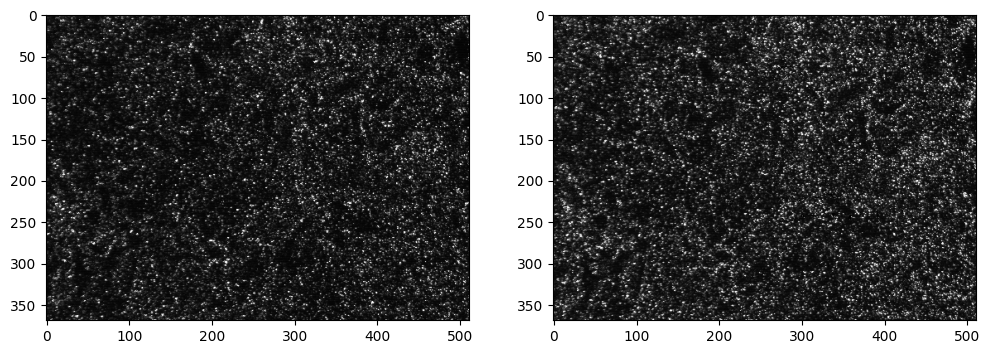

In [13]:
frame_a  = tools.imread( 'PIV/test1/exp1_001_a.bmp' )
frame_b  = tools.imread( 'PIV/test1/exp1_001_b.bmp' )

fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)

In [14]:
winsize = 32 # pixels, interrogation window size in frame A
searchsize = 38  # pixels, search in image B
overlap = 12 # pixels, 50% overlap
dt = 0.02 # sec, time interval between pulses


u0, v0, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32), 
                                                       frame_b.astype(np.int32), 
                                                       window_size=winsize, 
                                                       overlap=overlap, 
                                                       dt=dt, 
                                                       search_area_size=searchsize, 
                                                       sig2noise_method='peak2peak')

In [15]:
x, y = pyprocess.get_coordinates( image_size=frame_a.shape, 
                                 search_area_size=searchsize, 
                                 overlap=overlap )

(array([17.,  0.,  0.,  0., 11., 36., 67., 60., 42., 14.]),
 array([0.        , 0.26559974, 0.53119948, 0.79679922, 1.06239896,
        1.32799871, 1.59359845, 1.85919819, 2.12479793, 2.39039767,
        2.65599741]),
 <BarContainer object of 10 artists>)

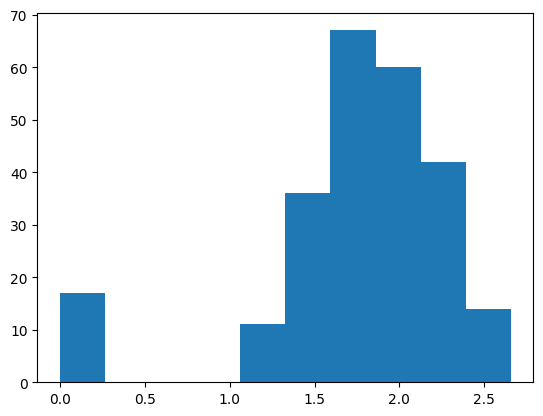

In [16]:
invalid_mask = validation.sig2noise_val(sig2noise, threshold = 1.05 )
# if you need more detailed look, first create a histogram of sig2noise
plt.hist(sig2noise.flatten())
# to see where is a reasonable limit

In [17]:
# filter out outliers that are very different from the
# neighbours

u2, v2 = filters.replace_outliers( u0, v0,
                                  invalid_mask,
                                  method='localmean', 
                                  max_iter=3, 
                                  kernel_size=3)

In [18]:
# convert x,y to mm
# convert u,v to mm/sec

x, y, u3, v3 = scaling.uniform(x, y, u2, v2, 
                               scaling_factor = 96.52 )

# 0,0 shall be bottom left, positive rotation rate is counterclockwise
x, y, u3, v3 = tools.transform_coordinates(x, y, u3, v3)

In [19]:
#save in the simple ASCII table format
tools.save('exp1_001.txt' , x, y, u3, v3, invalid_mask)

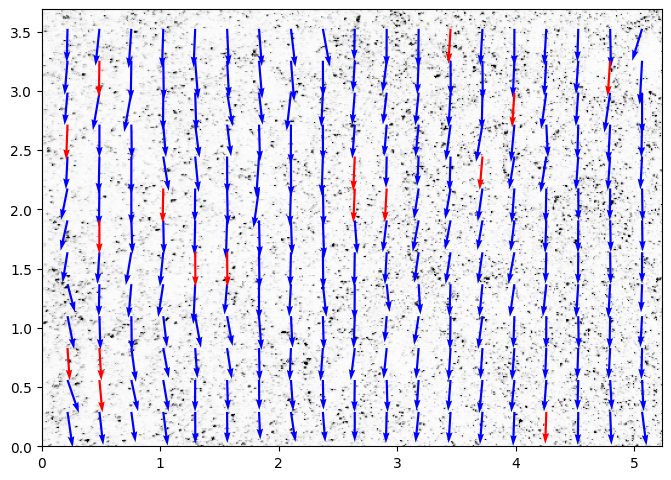

In [20]:
fig, ax = plt.subplots(figsize=(8,8))
tools.display_vector_field('exp1_001.txt', 
                           ax=ax, scaling_factor=96.52, 
                           scale=50, # scale defines here the arrow length
                           width=0.0035, # width is the thickness of the arrow
                           on_img=True, # overlay on the image
                           image_name='PIV/test1/exp1_001_a.bmp');



Быстрая обработка двух последовательных изображений

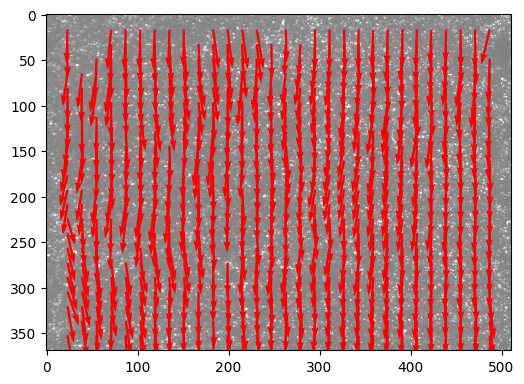

In [21]:
from openpiv import piv
piv.simple_piv(frame_a, frame_b);

## 2.2. Устранение артефактов PIV с помощью маскирования

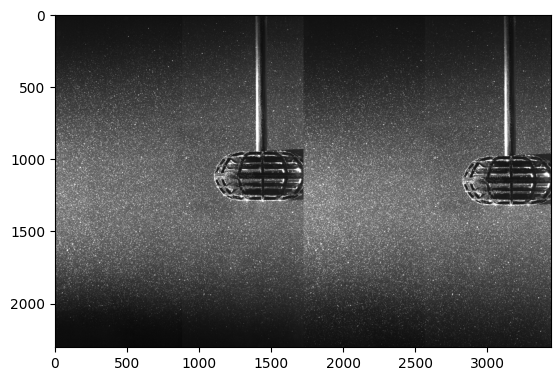

In [22]:
file_a = 'PIV/test4/Camera1-0101.tif'
file_b = 'PIV/test4/Camera1-0102.tif'

im_a  = tools.imread( file_a )
im_b  = tools.imread( file_b )
plt.imshow(np.c_[im_a,im_b],cmap='gray')

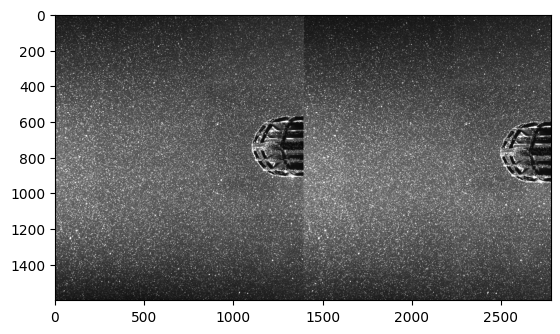

In [23]:
# let's crop the region of interest
frame_a =  im_a[380:1980,0:1390]
frame_b =  im_b[380:1980,0:1390]
plt.imshow(np.c_[frame_a,frame_b],cmap='gray')

In [24]:
file_с = 'PIV/test4/cropped.png'
cv2.imwrite(file_с, frame_a)

True

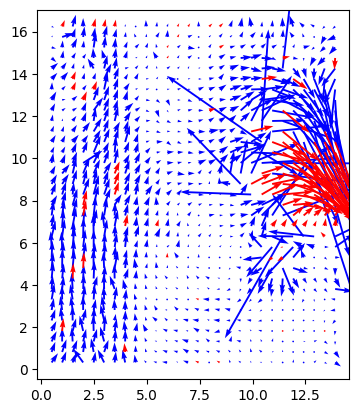

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [25]:
# Process the original cropped image and see the OpenPIV result:

# typical parameters:
window_size = 32 #pixels
overlap = 16 # pixels
search_area_size = 64 # pixels 
frame_rate = 40 # fps
scaling_factor = 96.52 # micron/pixel




# process again with the masked images, for comparison# process once with the original images
u, v, sig2noise = pyprocess.extended_search_area_piv(
                                                       frame_a.astype(np.int32), frame_b.astype(np.int32), 
                                                       window_size = window_size,
                                                       overlap = overlap, 
                                                       dt=1./frame_rate, 
                                                       search_area_size = search_area_size, 
                                                       sig2noise_method = 'peak2peak')

x, y = pyprocess.get_coordinates(frame_a.shape, 
                               search_area_size, 
                               overlap )

mask_g = validation.global_val( u, v, (-300.,300.),(-300.,300.))
mask_s2n = validation.sig2noise_val(sig2noise, threshold = 1.1 )

invalid = mask_s2n | mask_g

u, v = filters.replace_outliers( u, v, invalid, method='localmean', max_iter = 3, kernel_size = 3)


x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = 96.52 )
# save to a file

x, y, u, v = tools.transform_coordinates(x, y, u, v)
tools.save('test.txt' , x, y, u, v, invalid)

tools.display_vector_field('test.txt', scale=5, width=0.006)

In [26]:
u.shape

(33, 28)

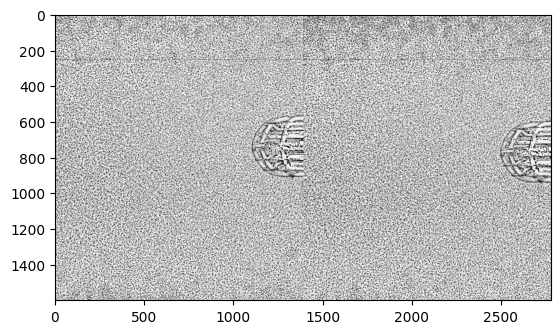

In [27]:
# masking using optimal (manually tuned) set of parameters and the right method:
masked_a, _ = preprocess.dynamic_masking(frame_a,method='edges',filter_size=7,threshold=0.01)
masked_b, _ = preprocess.dynamic_masking(frame_b,method='edges',filter_size=7,threshold=0.01)
plt.imshow(np.c_[masked_a,masked_b],cmap='gray')

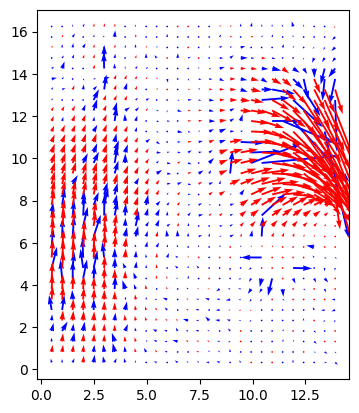

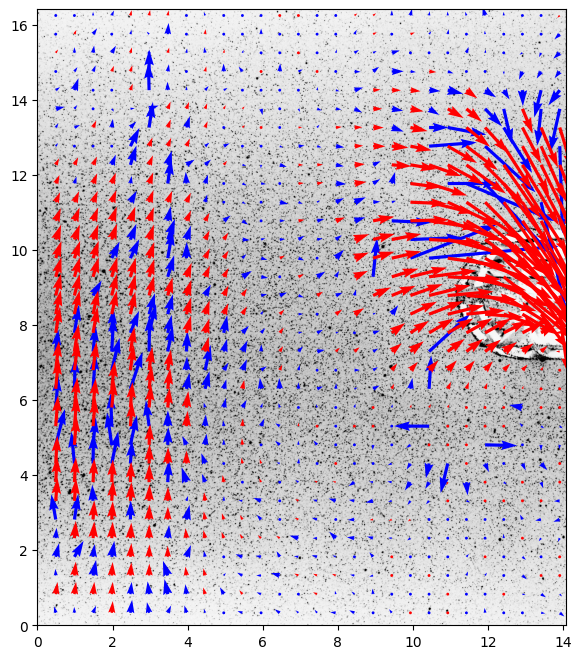

In [28]:
# Process the masked cropped image and see the OpenPIV result:

# process again with the masked images, for comparison# process once with the original images
u, v, sig2noise = pyprocess.extended_search_area_piv(
                                                       masked_a.astype(np.int32) , masked_b.astype(np.int32), 
                                                       window_size = window_size,
                                                       overlap = overlap, 
                                                       dt=1./frame_rate, 
                                                       search_area_size = search_area_size, 
                                                       sig2noise_method = 'peak2peak')
x, y = pyprocess.get_coordinates(masked_a.shape, 
                               search_area_size, 
                               overlap )

mask = validation.global_val( u, v, (-300.,300.),(-300.,300.))

mask = validation.sig2noise_val(sig2noise, threshold = 1.1)


u, v = filters.replace_outliers( u, v, mask, method='localmean', max_iter = 3, kernel_size = 3)
x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = scaling_factor )
# save to a file
x, y, u, v = tools.transform_coordinates(x, y, u, v)
tools.save('test_masked.txt', x, y, u, v, mask, fmt='%9.6f', delimiter='\t')


tools.display_vector_field('test_masked.txt', scale=5, width=0.006, image_name=file_a)

fig, ax = plt.subplots(figsize=(8,8))
tools.display_vector_field('test_masked.txt', 
                           ax=ax, scaling_factor=96.52, 
                           scale=5, # scale defines here the arrow length
                           width=0.006, # width is the thickness of the arrow
                           on_img=True, # overlay on the image
                           image_name=file_с);

## 2.3. Обработка видео-данных

In [29]:
def piv_process(im1, im2, ax, camera):
    if isinstance(im1, str):
        im1 = tools.imread(im1)
        im2 = tools.imread(im2)

    u, v, s2n = pyprocess.extended_search_area_piv(
        im1.astype(np.int32), im2.astype(np.int32), window_size=32,
        overlap=16, search_area_size=32
    )
    x, y = pyprocess.get_coordinates(image_size=im1.shape,
                                     search_area_size=32, overlap=16)

    valid = s2n > np.percentile(s2n,5)
    
    ax.imshow(im1, cmap=plt.get_cmap("gray"), alpha=0.5, origin="upper")
    ax.quiver(x[valid], y[valid], u[valid], -v[valid], scale=70, color='r',width=.005)
    plt.show()
    camera.snap()
    
    return x, y, u, v

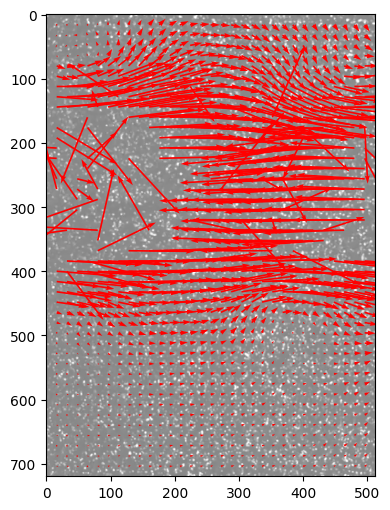

In [30]:
vidcap = cv2.VideoCapture('PIV/test_movie/videoplayback.mp4')
success, image1 = vidcap.read()
count = 0
U = []
V = []

fig, ax = plt.subplots(figsize=(6, 6))
camera = Camera(fig)

while success and count < 50:
    # cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file      
    success, image2 = vidcap.read()
    # print('Read a new frame: ', success)
    if success:
        x,y,u,v = piv_process(image1.sum(axis=2), image2.sum(axis=2), ax, camera);
        image1 = image2.copy()
        count += 1
        U.append(u)
        V.append(v)

In [31]:
animation = camera.animate()
animation.save('PIV/test_movie/result.gif', writer = 'ffmpeg')

In [32]:
U = np.stack(U)
Umean = np.mean(U, axis=0)
V = np.stack(V)
Vmean = np.mean(V,axis=0)

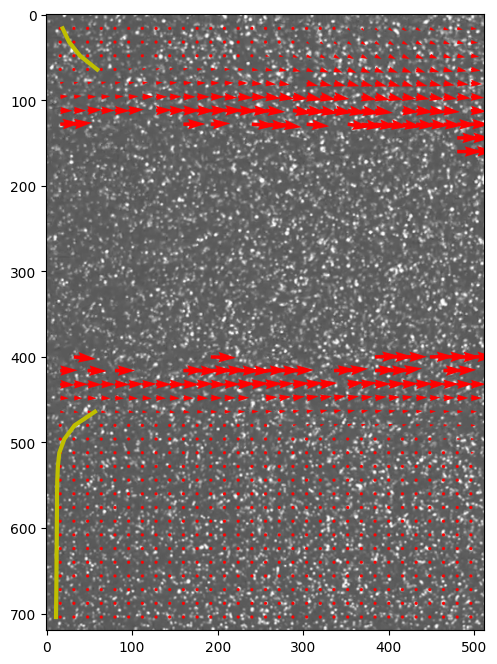

In [33]:
fig,ax = plt.subplots(figsize=(8,8))
ax.imshow(image1,alpha=0.7)
ax.quiver(x,y,Umean,Vmean,scale=200,color='r',width=.008)
plt.plot(np.mean(Umean,axis=1)*20,y[:,0],color='y',lw=3)
plt.show()

# Multiple Object Tracking
https://docs.ultralytics.com/modes/track/

## Использованные материалы
- https://learnopencv.com/optical-flow-in-opencv/
- http://www.openpiv.net/openpiv-python/